# Plots for main figure of paper
Data from jointly clustered datasets.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [2]:
import sys
import anndata
# import scvi

# import scanpy as sc
import numpy as np
from scipy import stats

from upsetplot import UpSet

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

# Custom violinplot code
from plotting_funcs import violinplot

import gget

import pandas as pd

# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

In [3]:
# set random seed
np.random.seed(926)

In [4]:
def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load AnnData object

In [5]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [6]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [7]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

# Create columns containing general celltype assignment - ignoring cluster separation
adata.obs['celltype_g'] = adata.obs['celltype'].str.replace('\d+', '')

adata.obs.head()

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_g
barcode,,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control,mural cells
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control,microglia
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control,astrocytes
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control,GABAergic neurons


Split experiment and control data into separate AnnData objects for violin plots:

In [8]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

Define standard set of celltypes to plot (excluding clusters with < 100 cells):

In [9]:
celltypes_standard = [
    "GABAergic neurons 1",
    "GABAergic neurons 2",
    "astrocytes 1",
    "astrocytes 2",
    "microglia 1",
    "microglia 2",
    "glutamatergic neurons 1",
    "glutamatergic neurons 2",
    "glutamatergic neurons 3",
    "glutamatergic neurons 4"
]

In [10]:
celltype_labels = [
    "GABAergic neurons 1",
    "GABAergic neurons 2",
    "Astrocytes 1",
    "Astrocytes 2",
    "Microglia 1",
    "Microglia 2",
    "Glutamatergic neurons 1",
    "Glutamatergic neurons 2",
    "Glutamatergic neurons 3",
    "Glutamatergic neurons 4",
]

___

## Does each celltype cluster contain an equal number of cells from each batch/dataset?

Let's look at the actual number of cells from each batch for each celltype:

In [11]:
# Normalize each celltype count to total number of cells in that batch by dividing
df_normalized = (adata.obs.groupby("celltype")["batch"].value_counts() / adata.obs.groupby("batch")["species"].count()).unstack().fillna(0)
df_normalized.columns = df_normalized.columns.astype(str)
df_normalized["total normalized count"] = df_normalized.sum(axis=1).values

df_normalized["control1_fraction"] = (df_normalized["control1"] / df_normalized["total normalized count"]).values
df_normalized["control2_fraction"] = (df_normalized["control2"] / df_normalized["total normalized count"]).values
df_normalized["experiment1_fraction"] = (df_normalized["experiment1"] / df_normalized["total normalized count"]).values
df_normalized["experiment2_fraction"] = (df_normalized["experiment2"] / df_normalized["total normalized count"]).values

df_normalized["total cellcount"] = adata.obs.groupby("celltype").size().values.astype(int)

df_normalized

batch,control1,control2,experiment1,experiment2,total normalized count,control1_fraction,control2_fraction,experiment1_fraction,experiment2_fraction,total cellcount
celltype,,,,,,,,,,
GABAergic neurons 1,0.118611,0.155614,0.109006,0.093180,0.476412,0.248968,0.326638,0.228806,0.195588,4084
GABAergic neurons 2,0.047834,0.045312,0.034778,0.040609,0.168532,0.283825,0.268861,0.206359,0.240955,1508
GABAergic neurons 3,0.002049,0.001819,0.001038,0.001628,0.006533,0.313551,0.278429,0.158899,0.249121,59
astrocytes 1,0.074465,0.049281,0.038541,0.065511,0.227798,0.326890,0.216335,0.169191,0.287584,2127
astrocytes 2,0.024890,0.043327,0.029587,0.078288,0.176092,0.141346,0.246049,0.168022,0.444584,1695
glutamatergic neurons 1,0.134999,0.104845,0.111861,0.108236,0.459941,0.293515,0.227954,0.243207,0.235325,4144
glutamatergic neurons 2,0.113490,0.148338,0.060472,0.030518,0.352818,0.321667,0.420438,0.171398,0.086497,2846
glutamatergic neurons 3,0.041790,0.074252,0.077861,0.043376,0.237279,0.176123,0.312930,0.328143,0.182804,1990
glutamatergic neurons 4,0.009526,0.004630,0.005840,0.010579,0.030575,0.311552,0.151443,0.190992,0.346013,296


In [12]:
# Only keep celltypes to plot
df_normalized = df_normalized.loc[celltypes_standard]

Function to plot ln(FC):

In [13]:
def plot_lnfc(ax):
    exp = df_normalized[["experiment1", "experiment2"]].sum(axis=1)
    ctrl = df_normalized[["control1", "control2"]].sum(axis=1)

    x = df_normalized.index.values
    y = []
    cell_counts = df_normalized["total cellcount"].values
    cell_color = "navy"

    counter = 0
    del_idx = []

    # Calculate log(fold change)
    for i, exp_value in enumerate(exp):
        if cell_counts[i] < 100:
            # Collect indeces of labels to delete from x labels
            del_idx.append(i)
            continue
        else:
            y_temp = np.log(exp_value / ctrl[i])
            y.append(y_temp)
            if exp_value >= ctrl[i]:
                ax.text(x = counter, y = y_temp + 0.1, s = cell_counts[i], size = 8, ha='center', c=cell_color)
            if ctrl[i] >= exp_value:
                ax.text(x = counter, y = y_temp - 0.25, s = cell_counts[i], size = 8, ha='center', c=cell_color)
            counter +=1

    x = np.delete(x, del_idx)

    # Plot stem/scatter plot
    ax.vlines(x, 0, y, color="black", linestyle="-", lw=1, zorder=-1)
    ax.scatter(x , y, c="black", s=30)

    ax.set(
        **{
            "title": "ln(Fold Change) in cell count between TetX and control",
            "ylabel": "ln(cellcount$_{tetx}$ / cellcount$_{control}$)",
            "ylim": (-1.7, 1.7)
            #     "xlabel": "Celltypes"
        }
    )

    # ax.set_yscale('log')

    # labels = ["", "3", "2", "1", "0", "1", "2", "3"]
    # ax.set_yticklabels(labels)

    ax.axhline(y=0, color="black", linestyle="-", lw=1, zorder=-1)
    ax.set_xticklabels(celltype_labels, rotation=45, ha="right")

    ax.text(-0.2, np.log(3)+0.05, "Fold Change = 3", ha="left", size=10, c='red')
    ax.axhline(y=np.log(3), color="red", linestyle="--", lw=1, zorder=-1)
    ax.axhline(y=-np.log(3), color="red", linestyle="--", lw=1, zorder=-1)

    # Add blocks and text separating each comparison category
    ax.axhspan(-1.7, 0, facecolor='aliceblue', alpha=0.5, zorder=-1)
    ax.axhspan(0, 1.7, facecolor='moccasin', alpha=0.5, zorder=-1)
    ax.text(-0.2, -1.55, "cellcount$_{control}$ > cellcount$_{tetx}$", ha="left", size=10)
    ax.text(-0.2, 1.45, "cellcount$_{tetx}$ > cellcount$_{control}$", ha="left", size=10)
    ax.text(9.2, 1.45, "Total number of cells in cluster", ha="right", c=cell_color, size=10)

    ax.margins(x=0.03, y=0.01)
    ax.grid(False)
    ax.xaxis.grid(color='gray', ls='--', lw=0.1)
    ax.yaxis.grid(color='gray', ls='--', lw=0.1)
    ax.set_axisbelow(True)

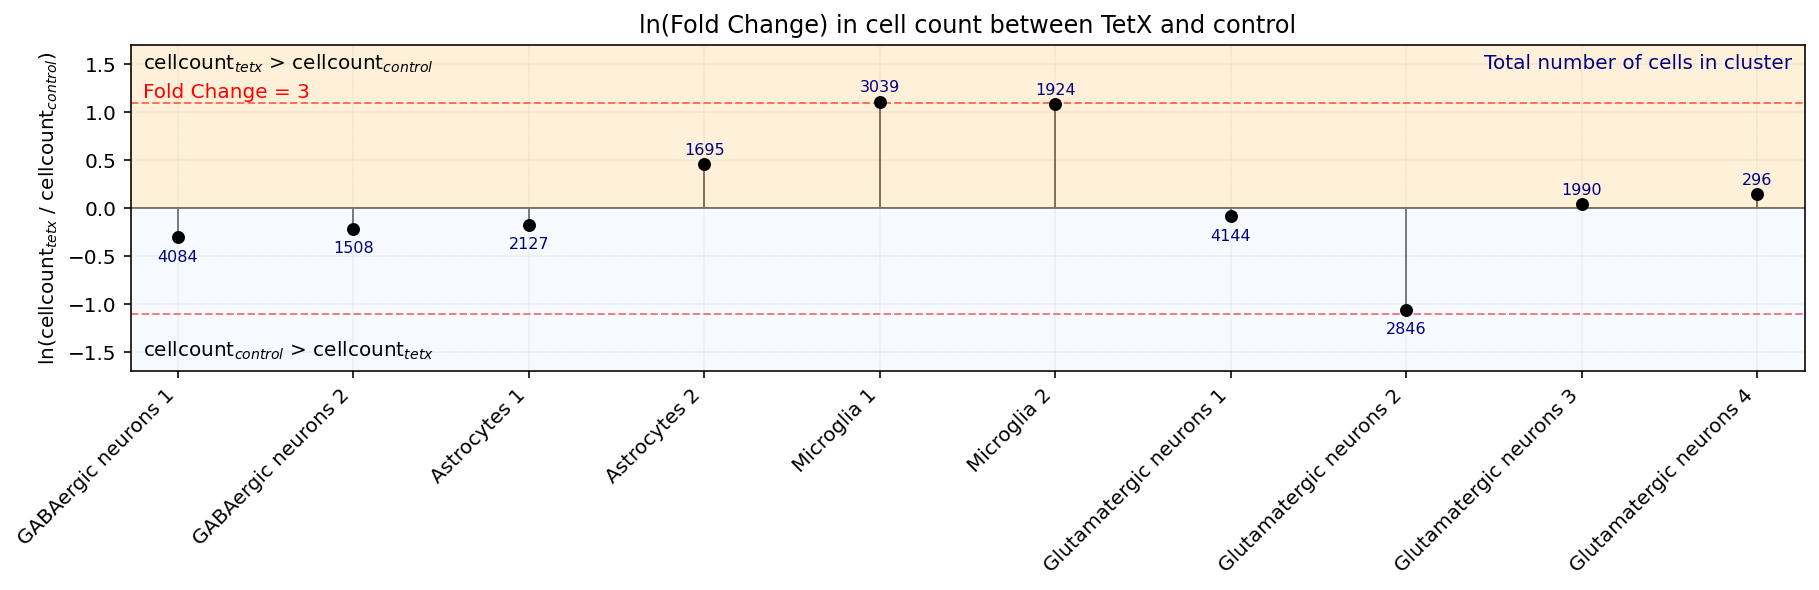

In [14]:
fig, ax = plt.subplots(figsize = (15, 3))

plot_lnfc(ax)

fig.savefig("figures/final/4_celltype_abundance.svg", dpi=300, bbox_inches="tight")
fig.savefig("figures/final/4_celltype_abundance.png", dpi=300, bbox_inches="tight")

Function to plot violin plots:

In [15]:
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

def violinplot(adata_exp, adata_ctrl, genes, labels, celltypes, celltype_labels, axs, alpha=0.05, fold_change_min=2):
    ## Find the indeces of the celltypes/clusters to be used
    # If the first celltype does not contain a number (e.g. "microglia" versus "microglia_1"),
    # use general celltype (celltype_g) to find all of the clusters for that celltye
    # (This is the case for data from the separately clustered dataset)
    if any(map(str.isdigit, celltypes[0])) == False:
        print("Including all clusters for each celltype (obs column: celltype_g).")
        # Define celltypes and celltype indeces in both datasets
        celltype_exp_idx = [np.where(adata_exp.obs.celltype_g == i)[0] for i in celltypes]
        celltype_ctrl_idx = [np.where(adata_ctrl.obs.celltype_g == i)[0] for i in celltypes]
    # Else, use individual clusters
    else:
        print("Individual cluster analysis (obs column: celltype).")
        # Define celltypes and celltype indeces in both datasets
        celltype_exp_idx = [np.where(adata_exp.obs.celltype == i)[0] for i in celltypes]
        celltype_ctrl_idx = [np.where(adata_ctrl.obs.celltype == i)[0] for i in celltypes]

    lidx = np.arange(len(celltypes))*2
    
    fontsize_star = 20
    
    if len(genes) < 2:
        axs = [axs]

    for cidx, (gene, ax) in enumerate(zip(genes, axs)):
        ## Get counts for this gene for all EXP cells
        x_exp_temp = nd(adata_exp.X[:, adata_exp.var.index.str.contains(gene)].todense())
        # Group EXP normalized UMI counts per celltype
        x_exp=[]
        for idx_array in celltype_exp_idx:
            x_exp.append([x_exp_temp[i] for i in idx_array])

        v1 = ax.violinplot(x_exp, showmedians=False, showextrema=False, positions=lidx+0.3)

        ## Get counts for this gene for all CTRL cells
        x_ctrl_temp = nd(adata_ctrl.X[:, adata_ctrl.var.index.str.contains(gene)].todense())
        # Group CTRL normalized UMI counts per celltype
        x_ctrl=[]
        for idx_array in celltype_ctrl_idx:
            x_ctrl.append([x_ctrl_temp[i] for i in idx_array])

        v2 = ax.violinplot(x_ctrl, showmedians=False, showextrema=False, positions=lidx-0.3)
          
        ## Welch's t-test and fold change of mean calculation
        fold_changes = [] 
        p_values = []
        for index, cell_array in enumerate(x_exp):
            # Perform Welch’s t-test, which does not assume equal population variance
            s, p = stats.ttest_ind(cell_array, x_ctrl[index], equal_var=False)
            # Save p-value for violin plot body transparency and heatmap
            p_values.append(p)
            
            if np.mean(cell_array) > np.mean(x_ctrl[index]):
                fold_change = np.mean(cell_array) / np.mean(x_ctrl[index])
                if p < alpha and fold_change >= fold_change_min:
                    ax.annotate("*", (lidx[index], 0.5*ax.get_ylim()[1]), ha="center", c="black", fontsize=fontsize_star)
                    
                # Save foldchange for violin plot body transparency and heatmap
                fold_changes.append(fold_change)
                    
            if np.mean(cell_array) <= np.mean(x_ctrl[index]):
                fold_change = np.mean(x_ctrl[index]) / np.mean(cell_array)
                if p < alpha and fold_change >= fold_change_min:
                    ax.annotate("*", (lidx[index], 0.5*ax.get_ylim()[1]), ha="center", c="black", fontsize=fontsize_star)
                    
                # Save foldchange for violin plot body transparency and heatmap
                fold_changes.append(fold_change)
                    
        ## Set color and transparency of the violin plot bodies
        # Set transparency based on fold change (FC) and p-value
        # All violin plots showing an FC >= fold_change_min and p < alpha will be 100% opaque; 
        # for FCs < fold_change_min and p > alpha will be 10% opaque
        # Violin plots showing experiment data:
        for pcidx, pc in enumerate(v1["bodies"]):
            pc.set_facecolor(exp_color)  
            pc.set_edgecolor("black")
            if fold_changes[pcidx] >= fold_change_min and p_values[pcidx] < alpha:
                pc.set_alpha(1)
            else:
                pc.set_alpha(0.1)
        # Violin plots showing control data:
        for pcidx2, pc2 in enumerate(v2["bodies"]):
            pc2.set_facecolor(control_color)
            pc2.set_edgecolor("black")
            if fold_changes[pcidx2] >= fold_change_min and p_values[pcidx2] < alpha:
                pc2.set_alpha(1)
            else:
                pc2.set_alpha(0.1)

        ## Set up x- and y- tick labels, and distinct top and bottom axes  
        # Get total number of cells per celltype cluster
        cellcounts_exp=[]
        for array in x_exp:
            cellcounts_exp.append(len(array)) 
        cellcounts_ctrl=[]
        for array in x_ctrl:
            cellcounts_ctrl.append(len(array)) 

        xticklabels=[]    
        for i2, (celltype_label, cellcount) in enumerate(zip(celltype_labels, cellcounts_exp)):
            xticklabels.append("{} \n(Control: {}; TetX: {})".format(celltype_label, cellcounts_ctrl[i2], cellcount))

        if cidx==0:
            ax_top = ax.twiny()
            ax_top.set_xlim(ax.get_xlim()) # DO NOT DELETE THIS
            ax_top.set_ylim(ax.get_ylim()[0], 2.5*ax.get_ylim()[1]) # Slightly increase space on top of first row of plots
            ax_top.set_xticks(lidx)
            ax_top.set_xticklabels(xticklabels, rotation=45, ha="left", fontsize=13)
            ax_top.spines["top"].set_visible(False)
            ax_top.spines["left"].set_visible(False)
            ax_top.spines["bottom"].set_visible(False)
            ax_top.xaxis.grid(False) 

        if cidx == len(genes)-1:
            ax_bot = ax.twiny()
            ax_bot.set_xticks([])
            ax_bot.set_xticklabels([])
            ax_bot.spines["top"].set_visible(False)
            ax_bot.spines["left"].set_visible(False)
            ax_bot.spines["bottom"].set_visible(False)

        ax.yaxis.tick_right()
        ax.set_ylabel(labels[cidx], color="black",rotation="horizontal", ha="right", va="center", fontsize=fontsize)

        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_axisbelow(True)
        ax.xaxis.grid(False) 
        
        # Set y axis on log scale including 0
        ax.set_yscale('symlog')

        ax.tick_params(
            axis="x",          # changes apply to the x-axis
            which="both",      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off 

In [16]:
# Define genes and labels for violin plot
mhc_genes = ["_ENSTGUG00000017273.2", "_ENSTGUG00000004607.2"]
mhc_gene_names = ["MHC1\nENSTGUG00000017273.2", "B2M\nENSTGUG00000004607.2"]

Note: Regulation of CNS synapses by neuronal MHC class I https://pubmed.ncbi.nlm.nih.gov/17420446/

Abbreviations:  
MHC1 = Major Histocompatibility Complex, Class I (alpha chain-like)  
B2M = Beta-2-Microglobulin

Individual cluster analysis (obs column: celltype).


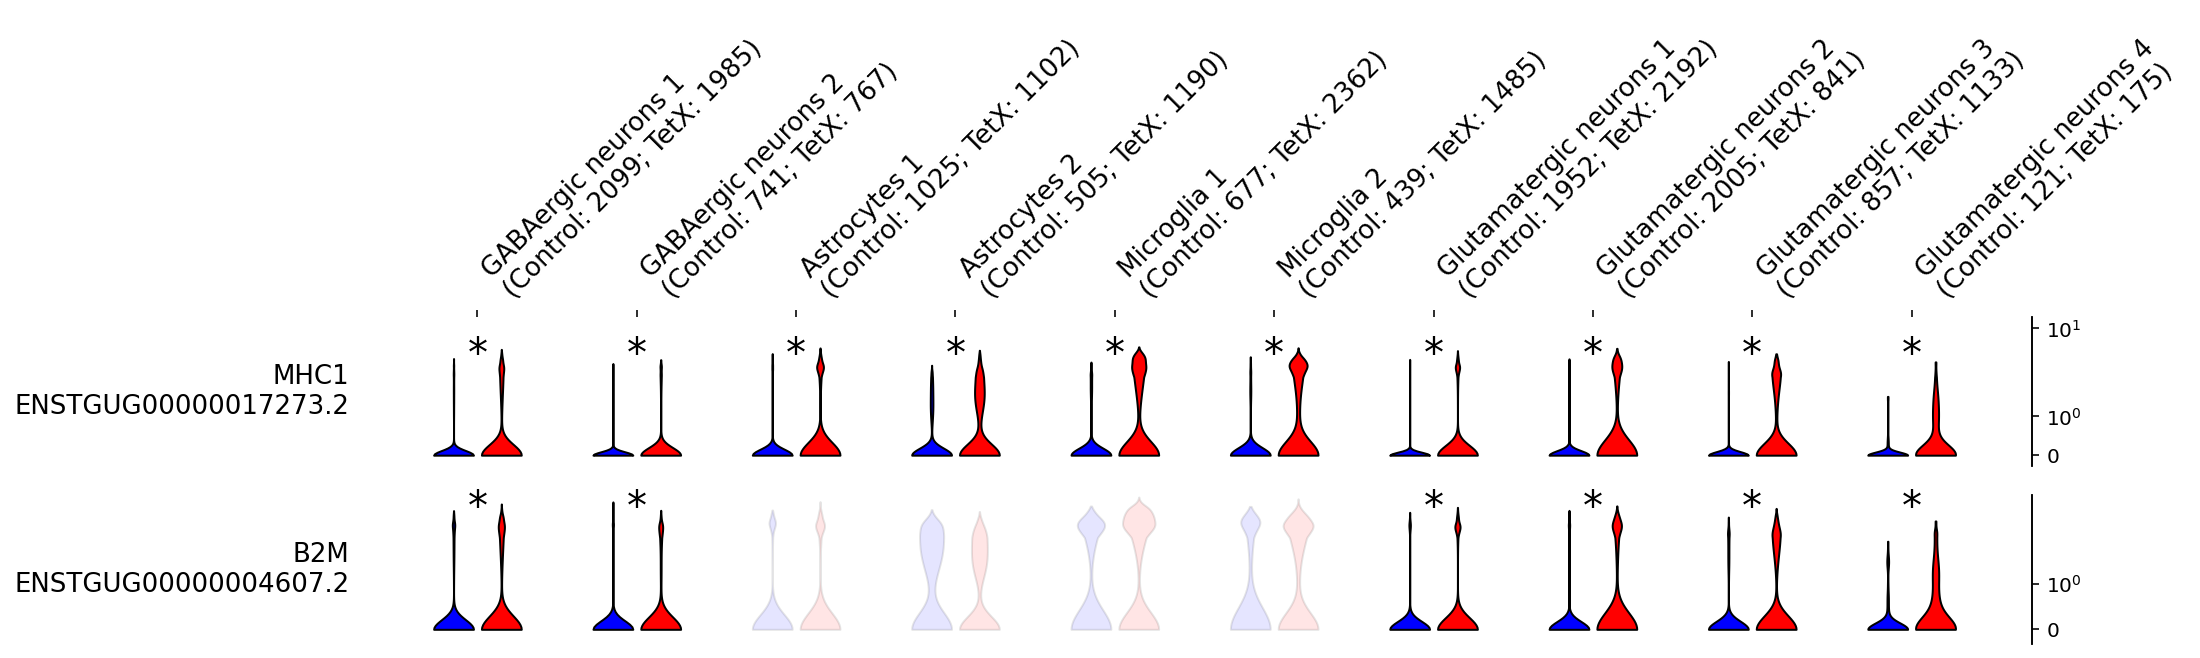

In [17]:
# Set violin plot parameters
genes = mhc_genes
labels = mhc_gene_names
celltypes = celltypes_standard

fig, axs = plt.subplots(figsize = (15, 3), nrows=len(genes))

fontsize = 13
control_color = "blue"
exp_color = "red"

# Plot violin plot
violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    celltype_labels = celltype_labels,
    axs=axs,
    fold_change_min=1.5,
)

fig.savefig("figures/final/4_mhc_b2m.svg", dpi=300, bbox_inches="tight")
fig.savefig("figures/final/4_mhc_b2m.png", dpi=300, bbox_inches="tight")